## 00. 환경설정

In [1]:
from collections import OrderedDict, defaultdict
from copy import copy
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm

from sklearn.metrics import log_loss, roc_auc_score
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## 01. Tensorflow로 DeepFM 구현
- Tensorflow keras를 활용하여 DeepFM을 구현합니다.
- DNN, FM Layer는 따로 Custom Layer로 만들어준 뒤 최종 DeepFM Tensorflow 모델에서 합쳐줍니다.
- 현재 모델 구조에서 각 Layer별로 다양한 옵션을 줄 수 있습니다.
    - (L2 regularization, Dropout, Batch normalization 등)

### DeepFM 개별 필드
- 필드별로 이름과 피쳐의 최대 개수(size)를 선언해줍니다.
    - ex) 성별의 경우 남자, 여자 => size : 2

In [2]:
class Feature:
    def __init__(self, name, size):
        self.name = name
        self.size = size

#### FM Custom Layer

In [3]:
class FM(tf.keras.layers.Layer):
    """
      Input shape
      - 3D tensor with shape: ``(batch_size, field_size, embedding_size)``.
      Output shape
      - 2D tensor with shape: ``(batch_size, 1)``.
    """

    def __init__(self, **kwargs):
        super(FM, self).__init__(**kwargs)

    def build(self, input_shape):
        
        if len(input_shape) != 3:
            raise ValueError("Unexpected inputs dimensions % d, expect to be 3 dimensions" % (len(input_shape)))
        
        super(FM, self).build(input_shape)

    def call(self, inputs, **kwargs):
        
        square_of_sum = tf.square(tf.reduce_sum(inputs, axis=1, keepdims=True))
        sum_of_square = tf.reduce_sum(inputs * inputs, axis=1, keepdims=True)
        cross_term = square_of_sum - sum_of_square
        cross_term = 0.5 * tf.reduce_sum(cross_term, axis=2, keepdims=False)
        
        return cross_term

    def compute_output_shape(self, input_shape):
        return (None, 1)

#### DNN Custom Layer

In [ ]:
class DNN(tf.keras.layers.Layer):
    """
      Input shape
      - 2D tensor: ``(batch_size, input_dim)``.
      Output shape
      - 2D tensor: ``(batch_size, hidden_size[-1])``.
    """

    def __init__(self, hidden_units, activation='relu', dropout_rate=0, seed=256, **kwargs):
        self.hidden_units = hidden_units
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.seed = seed

        super(DNN, self).__init__(**kwargs)

    def build(self, input_shape):

        if len(self.hidden_units) == 0:
            raise ValueError("hidden_units is empty")
        
        # DNN Layer는 각 hidden layer의 weight와 bias를 학습 파라미터로 선언합니다
        
        input_size = input_shape[-1]
        hidden_units = [int(input_size)] + list(self.hidden_units)
        self.kernels = [self.add_weight(name='kernel' + str(i),
                                        shape=(hidden_units[i], hidden_units[i + 1]),
                                        initializer=tf.keras.initializers.glorot_normal(),
                                        trainable=True
                                        ) for i in range(len(self.hidden_units))]
        self.bias = [self.add_weight(name='bias' + str(i),
                                     shape=(self.hidden_units[i],),
                                     initializer=tf.keras.initializers.Zeros(),
                                     trainable=True
                                     ) for i in range(len(self.hidden_units))]

        self.dropout_layers = [tf.keras.layers.Dropout(name='dropout' + str(i),
                                                       rate=self.dropout_rate, seed=self.seed + i
                                                      ) for i in range(len(self.hidden_units))]
        
        self.activation_layers = [tf.keras.layers.Activation(self.activation) for _ in range(len(self.hidden_units))]

        super(DNN, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, inputs, training=None, **kwargs):

        deep_input = inputs
        
        # hidden layer의 개수만큼 loop를 돌면서 layer를 계속 쌓아줍니다

        for i in range(len(self.hidden_units)):
            fc = tf.nn.bias_add(tf.tensordot(deep_input, self.kernels[i], axes=(-1, 0)), self.bias[i])
            fc = self.activation_layers[i](fc)
            fc = self.dropout_layers[i](fc, training=training)
            deep_input = fc
        
        return deep_input

    def compute_output_shape(self, input_shape):
        if len(self.hidden_units) > 0:
            shape = input_shape[:-1] + (self.hidden_units[-1], )
        else:
            shape = input_shape
        return tuple(shape)

    def get_config(self):
        config = {'activation': self.activation, 'hidden_units': self.hidden_units}
        base_config = super(DNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


### DeepFM Tensorflow 모델

In [26]:
def DeepFM(feature_columns, embedding_dim=4, dnn_hidden_units=(64, 32), activation='relu',
           dropout_rate=0, name = 'DeepFM'):
    
    # feature별로 tensorflow keras input을 선언합니다
    # feature별로 하나의 값을 가지기 때문에 shape = (1,) 입니다
    input_dict = OrderedDict()
    for feat in feature_columns:
        input_dict[feat.name] = tf.keras.layers.Input(shape=(1,), name=feat.name)
    
    # feature들을 모델의 input으로 사용합니다
    inputs = list(input_dict.values())
    
    # DeepFM의 linear한 1-order weight를 곱해서 더해줍니다
    # feature별로 1차원의 embedding matrix를 선언해 주는데, 이것이 linear interaction의 역할을 합니다
    linears = [tf.keras.layers.Embedding(feat.size, 1,
                                         embeddings_initializer=tf.keras.initializers.RandomNormal(),
                                         trainable=True,
                                         name='linear_' + feat.name)(input_dict[feat.name]) for feat in feature_columns]
    linear_sum = tf.keras.layers.add(linears, name='linear_sum')
    linear_logit = tf.keras.layers.Flatten(name='linear_logit')(linear_sum)
    
    # 개별 feature의 input을 embedding 해줍니다
    # 개별 feature에 대해 동일한 차원으로 embedding matrix를 선언한 뒤, FM Layer와 DNN Layer의 input으로 사용할 수 있도록 합니다
    embeddings = [tf.keras.layers.Embedding(feat.size, embedding_dim,
                                            embeddings_initializer=tf.keras.initializers.RandomNormal(),
                                            trainable=True,
                                            name='emb_' + feat.name)(input_dict[feat.name]) for feat in feature_columns]
    
    # DeepFM의 2-order feature interaction을 계산하여 더해줍니다
    fm_input = tf.keras.layers.Concatenate(axis=1, name='fm_input')(embeddings)
    fm_logit = FM(name='fm_logit')(fm_input)
    
    # DeepFM의 high-order interaction인 dnn layer를 선언해 dnn output과 dnn_logit을 구해줍니다
    embeddings_concat = tf.keras.layers.Concatenate(axis=-1, name = 'embeddings_concat')(embeddings)
    dnn_input = tf.keras.layers.Flatten(name='dnn_input')(embeddings_concat)
    dnn_output = DNN(hidden_units=dnn_hidden_units, activation=activation,
                     dropout_rate=dropout_rate, name='dnn_output')(dnn_input)
    dnn_logit = tf.keras.layers.Dense(1,
                                      use_bias=True,
                                      kernel_initializer=tf.keras.initializers.glorot_normal(),
                                      name = 'dnn_logit'
                                     )(dnn_output)
    
    # linear, fm, dnn의 output을 모두 더한 뒤 sigmoid를 통과시켜 최종 0~1 사이의 CTR 값을 출력하도록 합니다
    final_logit = tf.keras.layers.add([linear_logit, fm_logit, dnn_logit], name='final_logit')
    output = tf.keras.layers.Activation('sigmoid', name='sigmoid')(final_logit)
    
    # 마지막으로 input과 output을 맞춰서 keras model을 완성시킵니다
    model = tf.keras.models.Model(inputs=inputs, outputs=output, name = name)
    
    return model

## 02. DeepFM으로 CTR 예측하기

### 데이터 전처리

In [6]:
file_path = '../data/avazu-ctr-prediction/ad_click.csv'

In [7]:
parse_date = lambda x : datetime.strptime(x, '%y%m%d%H').strftime('%Y-%m-%d')
click_df = pd.read_csv(file_path, parse_dates = ['datetime'], date_parser = parse_date, header=0)

In [8]:
click_df = click_df[[
    'click', 'datetime', 'banner_pos', 'site_id', 'site_domain',
    'site_category', 'app_id', 'app_domain', 'app_category',
    'device_model', 'device_type', 'device_conn_type',
    'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'
]]

In [9]:
click_df

,click,datetime,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,device_conn_type,C1,C14,C15,C16,C17,C18,C19,C20,C21
0,0,2014-10-21,0,da79c793,71ed77a0,f028772b,ecad2386,7801e8d9,07d7df22,fce66524,...,0,1005,18993,320,50,2161,0,35,-1,157
1,0,2014-10-21,1,85f751fd,c4e18dd6,50e219e0,8c0dcd5a,7801e8d9,0f2161f8,1df52df3,...,0,1010,21665,320,50,2493,3,35,-1,117
2,0,2014-10-21,0,61a8c644,948ff336,50e219e0,ecad2386,7801e8d9,07d7df22,72dab84d,...,0,1002,19665,320,50,2253,2,303,-1,52
3,1,2014-10-21,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,8a4875bd,...,0,1005,15706,320,50,1722,0,35,-1,79
4,0,2014-10-21,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,cdfde03b,...,0,1005,20362,320,50,2333,0,39,-1,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,2014-10-30,1,57fe1b20,5b626596,f028772b,ecad2386,7801e8d9,07d7df22,56e6ab1d,...,0,1005,23722,320,50,2716,3,47,-1,23
199996,0,2014-10-30,0,85f751fd,c4e18dd6,50e219e0,53de0284,d9b5648e,0f2161f8,99e427c9,...,0,1005,21706,320,50,2498,3,41,100111,61
199997,0,2014-10-30,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,0fadd2fe,...,0,1005,22676,320,50,2616,0,35,-1,51
199998,0,2014-10-30,0,c135a32f,b8393312,50e219e0,ecad2386,7801e8d9,07d7df22,08ac11ab,...,0,1002,17894,320,50,2039,2,39,100077,32


In [10]:
from sklearn.preprocessing import LabelEncoder

features = [
    'banner_pos', 'site_id', 'site_domain','site_category', 'app_id', 'app_domain',
    'app_category', 'device_model', 'device_type', 'device_conn_type',
    'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'
]

click_df[features] = click_df[features].fillna('-1')
target = ['click']

# 각 피쳐에 대해서 0 이상의 자연수로 indexing 해줍니다
for feat in features:
    lbe = LabelEncoder()
    click_df[feat] = lbe.fit_transform(click_df[feat])

feature_columns = [Feature(feat, click_df[feat].max() + 1) for i, feat in enumerate(features)]

In [11]:
for feature in feature_columns:
    print(feature.name + ':', feature.size)

banner_pos: 7
site_id: 1804
site_domain: 1711
site_category: 20
app_id: 1776
app_domain: 112
app_category: 22
device_model: 3751
device_type: 4
device_conn_type: 4
C1: 7
C14: 1934
C15: 8
C16: 9
C17: 405
C18: 4
C19: 65
C20: 159
C21: 60


### DeepFM 모델 학습
- 날짜를 기준으로 train과 test 데이터를 나눕니다.

In [13]:
train_df = click_df[click_df['datetime'] <= '2014-10-28']
test_df = click_df[click_df['datetime'] > '2014-10-28']

- train / test 데이터를 생성합니다

In [40]:
train_X = {name:train_df[name].values for name in features}
train_y = train_df[target].values
test_X = {name:test_df[name].values for name in features}
test_y = test_df[target].values

- DeepFM 모델을 선언해줍니다

In [ ]:
model = DeepFM(feature_columns, embedding_dim = 20, dnn_hidden_units=(200, 200), activation='relu', dropout_rate=0)
model.compile("adam", "binary_crossentropy")

In [41]:
model.summary()

Model: "DeepFM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
banner_pos (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
site_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
site_domain (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
site_category (InputLayer)      [(None, 1)]          0                                            
_____________________________________________________________________________________________

In [42]:
history = model.fit(train_X, train_y,
                    batch_size=64, epochs=10, verbose=1, validation_data=(test_X, test_y))

Epoch 1/10
2501/2501 [==============================] - 13s 5ms/step - loss: 0.4142 - val_loss: 0.4059
Epoch 2/10
2501/2501 [==============================] - 15s 6ms/step - loss: 0.3946 - val_loss: 0.4117
Epoch 3/10
2501/2501 [==============================] - 14s 6ms/step - loss: 0.3815 - val_loss: 0.4134
Epoch 4/10
2501/2501 [==============================] - 13s 5ms/step - loss: 0.3690 - val_loss: 0.4243
Epoch 5/10
2501/2501 [==============================] - 12s 5ms/step - loss: 0.3574 - val_loss: 0.4322
Epoch 6/10
2501/2501 [==============================] - 12s 5ms/step - loss: 0.3456 - val_loss: 0.4492
Epoch 7/10
2501/2501 [==============================] - 11s 5ms/step - loss: 0.3344 - val_loss: 0.4608
Epoch 8/10
2501/2501 [==============================] - 11s 5ms/step - loss: 0.3243 - val_loss: 0.4770
Epoch 9/10
2501/2501 [==============================] - 12s 5ms/step - loss: 0.3144 - val_loss: 0.5136
Epoch 10/10
2501/2501 [==============================] - 11s 4ms/step - l

#### training loss와 validation loss
- CTR Prediction 문제는 epochs를 늘릴수록 성능이 떨어진다.

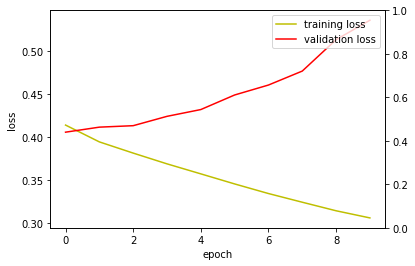

In [43]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='training loss')
loss_ax.plot(history.history['val_loss'], 'r', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

plt.show()

### DeepFM 모델 예측 및 평가
- epochs = 1로 하여 최종 모델 학습

In [50]:
model = DeepFM(feature_columns, embedding_dim = 20, dnn_hidden_units=(200, 200), activation='relu', dropout_rate=0.1)
model.compile("adam", "binary_crossentropy")
model.fit(train_X, train_y, batch_size=64, epochs=1, verbose=1, validation_data=(test_X, test_y))

2501/2501 [==============================] - 13s 5ms/step - loss: 0.4144 - val_loss: 0.4050


In [51]:
from sklearn.metrics import log_loss, roc_auc_score

pred_ans = model.predict(test_X, batch_size=256)
print("test LogLoss", round(log_loss(test_y, pred_ans), 4))
print("test AUC", round(roc_auc_score(test_y, pred_ans), 4))

test LogLoss 0.405
test AUC 0.7191
